# Portfolio Optimization Theory and Implementation

This notebook explores Modern Portfolio Theory (MPT) and implements various optimization strategies.

## Topics Covered:
- Efficient Frontier Construction
- Markowitz Mean-Variance Optimization
- Maximum Sharpe Ratio Portfolio
- Minimum Volatility Portfolio
- Risk Parity
- Black-Litterman Model

In [3]:
import sys
sys.path.append('..')
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, Latex

from src.data.fetcher import DataFetcher
from src.optimization.mean_variance import MeanVarianceOptimizer

plt.style.use('seaborn-v0_8-darkgrid')

## 1. Mathematical Foundation

### Portfolio Return and Risk

For a portfolio with weights $w = [w_1, w_2, ..., w_n]$:

**Expected Return:**
$$E(R_p) = \sum_{i=1}^{n} w_i \cdot E(R_i) = w^T \mu$$

**Portfolio Variance:**
$$\sigma_p^2 = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i w_j \sigma_{ij} = w^T \Sigma w$$

**Sharpe Ratio:**
$$S = \frac{E(R_p) - R_f}{\sigma_p}$$

In [5]:
# Load data from previous notebook
prices = pd.read_csv(os.getcwd()+'/data/processed/prices.csv', index_col=0, parse_dates=True)
returns = pd.read_csv(os.getcwd()+'/data/processed/returns.csv', index_col=0, parse_dates=True)

# Calculate expected returns and covariance
expected_returns = returns.mean() * 252  # Annualized
cov_matrix = returns.cov() * 252  # Annualized
risk_free_rate = 0.02  # 2% annual

print("Expected Annual Returns:")
print(expected_returns.round(3))
print("\nAnnualized Covariance Matrix:")
print(cov_matrix.round(4))

Expected Annual Returns:
AAPL    0.272
AMZN    0.310
GOOG    0.228
JPM     0.177
MSFT    0.287
dtype: float64

Annualized Covariance Matrix:
        AAPL    AMZN    GOOG     JPM    MSFT
AAPL  0.0843  0.0550  0.0517  0.0360  0.0562
AMZN  0.0550  0.1107  0.0625  0.0276  0.0608
GOOG  0.0517  0.0625  0.0818  0.0341  0.0578
JPM   0.0360  0.0276  0.0341  0.0771  0.0356
MSFT  0.0562  0.0608  0.0578  0.0356  0.0774


## 2. Efficient Frontier Construction

In [7]:
def calculate_portfolio_stats(weights, expected_returns, cov_matrix):
    """Calculate portfolio return and risk"""
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_vol

def generate_random_portfolios(n_portfolios, expected_returns, cov_matrix):
    """Generate random portfolio weights and calculate metrics"""
    n_assets = len(expected_returns)
    results = np.zeros((3, n_portfolios))
    weights_record = []
    
    for i in range(n_portfolios):
        # Generate random weights
        weights = np.random.random(n_assets)
        weights /= np.sum(weights)  # Normalize to sum to 1
        weights_record.append(weights)
        
        # Calculate metrics
        portfolio_return, portfolio_vol = calculate_portfolio_stats(weights, expected_returns, cov_matrix)
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_vol
        
        results[0, i] = portfolio_return
        results[1, i] = portfolio_vol
        results[2, i] = sharpe_ratio
    
    return results, weights_record

# Generate random portfolios
n_portfolios = 10000
results, weights_record = generate_random_portfolios(n_portfolios, expected_returns, cov_matrix)

# Create efficient frontier plot
fig = go.Figure()

# Add random portfolios
fig.add_trace(go.Scatter(
    x=results[1, :],
    y=results[0, :],
    mode='markers',
    marker=dict(
        size=5,
        color=results[2, :],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Sharpe Ratio")
    ),
    text=[f'Sharpe: {s:.2f}' for s in results[2, :]],
    name='Random Portfolios'
))

fig.update_layout(
    title='Efficient Frontier from Random Portfolios',
    xaxis_title='Annual Volatility',
    yaxis_title='Annual Return',
    xaxis=dict(tickformat='.0%'),
    yaxis=dict(tickformat='.0%'),
    height=600,
    template='plotly_white'
)

fig.show()

## 3. Optimization Strategies

In [9]:
# Initialize optimizer
optimizer = MeanVarianceOptimizer(risk_free_rate=risk_free_rate)

# Run different optimization strategies
strategies = {}

# 1. Maximum Sharpe Ratio
# 1. Maximum Sharpe Ratio - Custom implementation to ensure correctness
def maximize_sharpe_ratio(expected_returns, cov_matrix, risk_free_rate=0.02):
    n_assets = len(expected_returns)
    
    def negative_sharpe(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe = (portfolio_return - risk_free_rate) / portfolio_vol
        return -sharpe  # Negative because we're minimizing
    
    # Constraints
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
    
    # Bounds - all weights between 0 and 1
    bounds = tuple((0, 1) for _ in range(n_assets))
    
    # Try multiple starting points to avoid local optima
    best_result = None
    best_sharpe = -np.inf
    
    # Try 10 different random starting points
    for _ in range(10):
        # Random starting weights
        x0 = np.random.random(n_assets)
        x0 = x0 / np.sum(x0)
        
        result = minimize(
            negative_sharpe,
            x0=x0,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'ftol': 1e-9, 'maxiter': 1000}
        )
        
        if result.success:
            sharpe = -result.fun
            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_result = result
    
    # Also try equal weights as starting point
    x0 = np.array([1/n_assets] * n_assets)
    result = minimize(
        negative_sharpe,
        x0=x0,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'ftol': 1e-9, 'maxiter': 1000}
    )
    
    if result.success and -result.fun > best_sharpe:
        best_result = result
        best_sharpe = -result.fun
    
    return best_result.x, best_sharpe

# Run the optimization
max_sharpe_weights, max_sharpe_ratio = maximize_sharpe_ratio(expected_returns, cov_matrix, risk_free_rate)

# Calculate portfolio metrics
ms_return, ms_vol = calculate_portfolio_stats(max_sharpe_weights, expected_returns, cov_matrix)

# Create a result object that matches the expected format
class OptimizationResult:
    def __init__(self, weights, expected_return, volatility, sharpe_ratio, asset_names):
        self.weights = weights
        self.expected_return = expected_return
        self.volatility = volatility
        self.sharpe_ratio = sharpe_ratio
        self.asset_names = asset_names
    
    def get_allocation(self):
        return dict(zip(self.asset_names, self.weights))

max_sharpe_result = OptimizationResult(
    weights=max_sharpe_weights,
    expected_return=ms_return,
    volatility=ms_vol,
    sharpe_ratio=max_sharpe_ratio,
    asset_names=list(expected_returns.index)
)

strategies['Max Sharpe'] = max_sharpe_result

# 2. Minimum Volatility
min_vol_result = optimizer.optimize(prices, objective='min_volatility')
strategies['Min Volatility'] = min_vol_result

# Display results
for name, result in strategies.items():
    print(f"\n{name} Portfolio:")
    print(f"Expected Return: {result.expected_return:.2%}")
    print(f"Volatility: {result.volatility:.2%}")
    print(f"Sharpe Ratio: {result.sharpe_ratio:.3f}")
    print("\nWeights:")
    for asset, weight in result.get_allocation().items():
        if weight > 0.001:
            print(f"  {asset}: {weight:.1%}")

2025-06-18 01:04:39,028 - src.optimization.mean_variance - INFO - Prepared data for 5 assets
2025-06-18 01:04:39,028 - src.optimization.mean_variance - INFO - Date range: 2015-01-02 00:00:00 to 2023-12-29 00:00:00
2025-06-18 01:04:39,028 - src.optimization.mean_variance - INFO - Expected returns range: 13.9% to 25.5%
2025-06-18 01:04:39,029 - src.optimization.mean_variance - INFO - Running optimization with objective: min_volatility



Max Sharpe Portfolio:
Expected Return: 27.87%
Volatility: 24.89%
Sharpe Ratio: 1.039

Weights:
  AAPL: 23.0%
  AMZN: 26.6%
  JPM: 10.0%
  MSFT: 40.4%

Min Volatility Portfolio:
Expected Return: 19.07%
Volatility: 22.74%
Sharpe Ratio: 0.751

Weights:
  AAPL: 16.1%
  AMZN: 10.6%
  GOOG: 16.9%
  JPM: 41.1%
  MSFT: 15.2%


## 4. Interactive Efficient Frontier

In [11]:
# Calculate efficient frontier
def calculate_efficient_frontier(expected_returns, cov_matrix, n_points=100):
    n_assets = len(expected_returns)
    
    # Constraints
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n_assets))
    
    # Target returns
    min_ret = expected_returns.min()
    max_ret = expected_returns.max()
    target_returns = np.linspace(min_ret, max_ret, n_points)
    
    frontier_volatility = []
    frontier_returns = []
    frontier_weights = []
    
    for target in target_returns:
        # Add return constraint
        cons = [constraints,
                {'type': 'eq', 'fun': lambda x, target=target: calculate_portfolio_stats(x, expected_returns, cov_matrix)[0] - target}]
        
        # Minimize volatility for target return
        result = minimize(
            lambda x: calculate_portfolio_stats(x, expected_returns, cov_matrix)[1],
            x0=np.array([1/n_assets] * n_assets),
            method='SLSQP',
            bounds=bounds,
            constraints=cons
        )
        
        if result.success:
            ret, vol = calculate_portfolio_stats(result.x, expected_returns, cov_matrix)
            frontier_returns.append(ret)
            frontier_volatility.append(vol)
            frontier_weights.append(result.x)
    
    return np.array(frontier_volatility), np.array(frontier_returns), frontier_weights

# Calculate frontier
frontier_vol, frontier_ret, frontier_weights = calculate_efficient_frontier(expected_returns, cov_matrix)

# Create interactive plot
fig = go.Figure()

# Add efficient frontier
fig.add_trace(go.Scatter(
    x=frontier_vol,
    y=frontier_ret,
    mode='lines',
    name='Efficient Frontier',
    line=dict(color='red', width=3)
))

# Add random portfolios
fig.add_trace(go.Scatter(
    x=results[1, :],
    y=results[0, :],
    mode='markers',
    marker=dict(size=3, color='lightblue', opacity=0.5),
    name='Random Portfolios',
    showlegend=False
))

# Add optimal portfolios
for name, result in strategies.items():
    fig.add_trace(go.Scatter(
        x=[result.volatility],
        y=[result.expected_return],
        mode='markers',
        marker=dict(size=15, symbol='star'),
        name=name
    ))

# Add individual assets
for asset in expected_returns.index:
    vol = np.sqrt(cov_matrix.loc[asset, asset])
    ret = expected_returns[asset]
    fig.add_trace(go.Scatter(
        x=[vol],
        y=[ret],
        mode='markers+text',
        marker=dict(size=10, symbol='diamond'),
        text=[asset],
        textposition='top center',
        name=asset
    ))

fig.update_layout(
    title='Complete Efficient Frontier Analysis',
    xaxis_title='Annual Volatility',
    yaxis_title='Annual Return',
    xaxis=dict(tickformat='.0%'),
    yaxis=dict(tickformat='.0%'),
    height=700,
    template='plotly_white'
)

fig.show()

## 5. Risk Parity Portfolio

In [13]:
def calculate_risk_parity_weights(cov_matrix):
    """
    Calculate risk parity weights where each asset contributes equally to portfolio risk
    """
    n_assets = len(cov_matrix)
    
    def risk_contribution(weights, cov_matrix):
        # Calculate portfolio volatility
        portfolio_var = np.dot(weights.T, np.dot(cov_matrix, weights))
        portfolio_vol = np.sqrt(portfolio_var)
        
        # Marginal contribution to risk
        marginal_contrib = np.dot(cov_matrix, weights)
        
        # Risk contribution of each asset (should sum to 1)
        contrib = (weights * marginal_contrib) / portfolio_var
        return contrib
    
    def objective(weights, cov_matrix):
        contrib = risk_contribution(weights, cov_matrix)
        # Target equal contribution: 1/n for each asset
        target_contrib = 1.0 / n_assets
        # Minimize squared deviations from target
        return np.sum((contrib - target_contrib) ** 2) * 1000  # Scale up for optimizer
    
    # Constraints and bounds
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # Don't allow 0 weights - use small minimum like 0.01
    bounds = tuple((0.01, 1) for _ in range(n_assets))
    
    # Better initial guess - inverse volatility weighting
    vols = np.sqrt(np.diag(cov_matrix.values))
    x0 = (1/vols) / np.sum(1/vols)
    
    # Optimize with better tolerance
    result = minimize(
        objective,
        x0=x0,
        args=(cov_matrix.values,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'ftol': 1e-10, 'maxiter': 1000}
    )
    
    return result.x

# Calculate risk parity weights
rp_weights = calculate_risk_parity_weights(cov_matrix)
rp_return, rp_vol = calculate_portfolio_stats(rp_weights, expected_returns, cov_matrix)
rp_sharpe = (rp_return - risk_free_rate) / rp_vol

print("Risk Parity Portfolio:")
print(f"Expected Return: {rp_return:.2%}")
print(f"Volatility: {rp_vol:.2%}")
print(f"Sharpe Ratio: {rp_sharpe:.3f}")
print("\nWeights:")
for asset, weight in zip(expected_returns.index, rp_weights):
    print(f"  {asset}: {weight:.1%}")

def risk_contribution(weights, cov_matrix):
    """
    Calculate risk contribution of each asset to portfolio risk
    """
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    marginal_contrib = np.dot(cov_matrix, weights)
    contrib = weights * marginal_contrib / portfolio_vol
    return contrib

# Calculate risk contributions - properly scaled to sum to 100%
def calculate_risk_contributions(weights, cov_matrix):
    portfolio_var = np.dot(weights.T, np.dot(cov_matrix, weights))
    marginal_contrib = np.dot(cov_matrix, weights)
    contrib = (weights * marginal_contrib) / portfolio_var
    return contrib / contrib.sum()  # Normalize to sum to 1

contrib = calculate_risk_contributions(rp_weights, cov_matrix.values)
print("\nRisk Contributions:")
for asset, cont in zip(expected_returns.index, contrib):
    print(f"  {asset}: {cont:.1%}")
print(f"Total: {contrib.sum():.1%}")  # Should be 100%

Risk Parity Portfolio:
Expected Return: 25.01%
Volatility: 23.23%
Sharpe Ratio: 0.990

Weights:
  AAPL: 19.4%
  AMZN: 17.8%
  GOOG: 19.2%
  JPM: 24.5%
  MSFT: 19.2%

Risk Contributions:
  AAPL: 20.0%
  AMZN: 20.0%
  GOOG: 20.0%
  JPM: 20.0%
  MSFT: 20.0%
Total: 100.0%


In [14]:
# Verification of optimization results
print("="*50)
print("VERIFICATION: Checking optimization results")
print("="*50)

# Check all Sharpe ratios
sharpe_ratios = {
    'Max Sharpe': max_sharpe_result.sharpe_ratio,
    'Min Volatility': min_vol_result.sharpe_ratio,
    'Risk Parity': rp_sharpe
}

# Find the highest Sharpe ratio
max_sharpe_name = max(sharpe_ratios, key=sharpe_ratios.get)
max_sharpe_value = sharpe_ratios[max_sharpe_name]

print("Sharpe Ratios:")
for name, sharpe in sharpe_ratios.items():
    print(f"  {name}: {sharpe:.3f}")

print(f"\nHighest Sharpe: {max_sharpe_name} ({max_sharpe_value:.3f})")

if max_sharpe_name != 'Max Sharpe':
    print("\n⚠️ WARNING: 'Max Sharpe' portfolio does NOT have the highest Sharpe ratio!")
    print("This indicates an optimization problem.")
else:
    print("\n✓ Max Sharpe optimization verified correct")

VERIFICATION: Checking optimization results
Sharpe Ratios:
  Max Sharpe: 1.039
  Min Volatility: 0.751
  Risk Parity: 0.990

Highest Sharpe: Max Sharpe (1.039)

✓ Max Sharpe optimization verified correct


## 6. Black Litterman

In [16]:
# Add this as a new section in your notebook

## 6. Black-Litterman Model Implementation

# Import the Black-Litterman model
from src.optimization.black_litterman import BlackLittermanModel

# Initialize the model
bl_model = BlackLittermanModel(
    cov_matrix=cov_matrix,
    risk_aversion=2.5,
    tau=0.05,
    risk_free_rate=risk_free_rate
)

# Define market weights (you can get actual market caps from yfinance)
# For now, let's use example weights
market_weights = pd.Series({
    'AAPL': 0.30,
    'MSFT': 0.25, 
    'GOOG': 0.20,
    'AMZN': 0.15,
    'JPM': 0.10
})

# Calculate equilibrium returns
equilibrium_returns = bl_model.calculate_equilibrium_returns(market_weights)

# Add your views
# Calculate views based on historical performance + adjustments
historical_annual_returns = returns.mean() * 252

# Create views as adjustments to historical returns
views = [
    {
        'type': 'absolute',
        'assets': ['AAPL'],
        # Bullish: historical return + 10% premium
        'return': float(historical_annual_returns['AAPL'] + 0.15),
        'confidence': 0.80
    },
 
    {
        'type': 'absolute',
        'assets': ['AMZN'],
        # Bullish: historical return + 15% premium
        'return': float(historical_annual_returns['AMZN'] + 0.15),
        'confidence': 0.80
    },
      {
        'type': 'absolute',
        'assets': ['GOOG'],
        # Bullish: historical return + 10% premium
        'return': float(historical_annual_returns['GOOG'] + 0.1),
        'confidence': 0.75
    },
    {
        'type': 'absolute',
        'assets': ['MSFT'],
        # Bullish: historical return + 10% premium
        'return': float(historical_annual_returns['MSFT'] - 0.05),
        'confidence': 0.75
    }
]

# Add a conservative view to promote diversification


if 'JPM' in historical_annual_returns:
    views.append({
        'type': 'absolute',
        'assets': ['JPM'],
        'return': float(historical_annual_returns['JPM']),  # Neutral view
        'confidence': 0.75
    })
# Get posterior returns
P, Q, Omega = bl_model.create_views(views)
posterior_returns = bl_model.calculate_posterior_returns(P, Q, Omega)

# Get posterior returns
P, Q, Omega = bl_model.create_views(views)
posterior_returns = bl_model.calculate_posterior_returns(P, Q, Omega)

# Optimize portfolio with Black-Litterman
bl_weights = bl_model.optimize_portfolio(posterior_returns)

# Calculate metrics for Black-Litterman portfolio
bl_return, bl_vol = calculate_portfolio_stats(bl_weights.values, posterior_returns, cov_matrix)
bl_sharpe = (bl_return - risk_free_rate) / bl_vol

# Create result object matching the format of other strategies
bl_result = OptimizationResult(
    weights=bl_weights.values,
    expected_return=bl_return,
    volatility=bl_vol,
    sharpe_ratio=bl_sharpe,
    asset_names=list(posterior_returns.index)
)

strategies['Black-Litterman'] = bl_result

# Print Black-Litterman results
print("Black-Litterman Portfolio:")
print(f"Expected Return: {bl_return:.2%}")
print(f"Volatility: {bl_vol:.2%}")
print(f"Sharpe Ratio: {bl_sharpe:.3f}")
print("\nWeights:")
for asset, weight in zip(bl_weights.index, bl_weights.values):
    if weight > 0.001:
        print(f"  {asset}: {weight:.1%}")

# Show how views affected the returns
print("\n\nReturn Comparison (Equilibrium vs Posterior):")
return_comparison = pd.DataFrame({
    'Equilibrium': equilibrium_returns,
    'Posterior': posterior_returns,
    'Change': posterior_returns - equilibrium_returns
})
print(return_comparison.round(4))

Black-Litterman Portfolio:
Expected Return: 30.10%
Volatility: 25.50%
Sharpe Ratio: 1.102

Weights:
  AAPL: 41.6%
  AMZN: 29.3%
  GOOG: 19.9%
  JPM: 3.8%
  MSFT: 5.4%


Return Comparison (Equilibrium vs Posterior):
      Equilibrium  Posterior  Change
AAPL       0.1538     0.3047  0.1509
AMZN       0.1589     0.3313  0.1725
GOOG       0.1477     0.2815  0.1338
JPM        0.0959     0.1699  0.0740
MSFT       0.1512     0.2717  0.1205


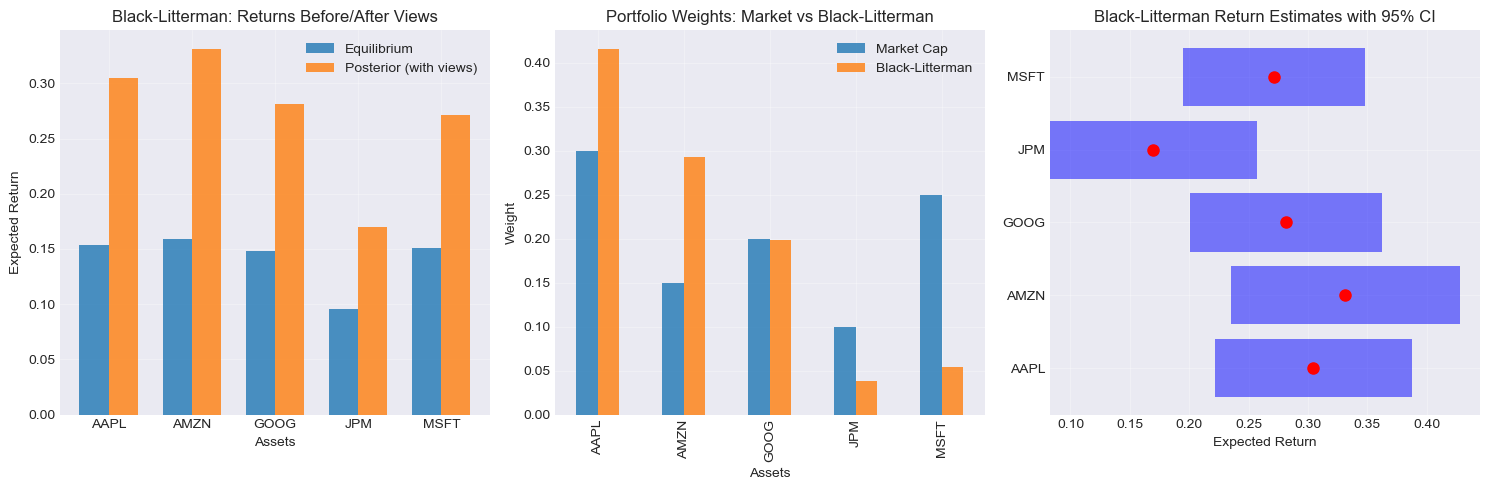

In [17]:
# Visualize Black-Litterman impact
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Return comparison
ax1 = axes[0]
x = np.arange(len(equilibrium_returns))
width = 0.35
ax1.bar(x - width/2, equilibrium_returns, width, label='Equilibrium', alpha=0.8)
ax1.bar(x + width/2, posterior_returns, width, label='Posterior (with views)', alpha=0.8)
ax1.set_xlabel('Assets')
ax1.set_ylabel('Expected Return')
ax1.set_title('Black-Litterman: Returns Before/After Views')
ax1.set_xticks(x)
ax1.set_xticklabels(equilibrium_returns.index)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Weight comparison
ax2 = axes[1]
# Get market cap weights vs optimized weights
comparison_weights = pd.DataFrame({
    'Market Cap': market_weights,
    'Black-Litterman': pd.Series(bl_weights.values, index=bl_weights.index)
})
comparison_weights.plot(kind='bar', ax=ax2, alpha=0.8)
ax2.set_xlabel('Assets')
ax2.set_ylabel('Weight')
ax2.set_title('Portfolio Weights: Market vs Black-Litterman')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Confidence intervals
ax3 = axes[2]
confidence_intervals = bl_model.get_confidence_intervals(posterior_returns)
assets_list = list(confidence_intervals.index)
y_pos = np.arange(len(assets_list))

# Plot confidence intervals
for i, asset in enumerate(assets_list):
    ax3.barh(i, 
             confidence_intervals.loc[asset, 'upper_bound'] - confidence_intervals.loc[asset, 'lower_bound'],
             left=confidence_intervals.loc[asset, 'lower_bound'],
             alpha=0.5, color='blue')
    ax3.plot(confidence_intervals.loc[asset, 'expected_return'], i, 'ro', markersize=8)

ax3.set_yticks(y_pos)
ax3.set_yticklabels(assets_list)
ax3.set_xlabel('Expected Return')
ax3.set_title('Black-Litterman Return Estimates with 95% CI')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Interactive Portfolio Builder

In [19]:
# Create interactive weight adjustment
assets = list(expected_returns.index)
n_assets = len(assets)

# Create sliders for each asset
sliders = {}
for asset in assets:
    sliders[asset] = widgets.FloatSlider(
        value=1/n_assets,
        min=0,
        max=1,
        step=0.01,
        description=asset,
        continuous_update=False
    )

# Output widget
output = widgets.Output()

def update_portfolio(*args):
    with output:
        output.clear_output(wait=True)
        
        # Get weights
        weights = np.array([sliders[asset].value for asset in assets])
        
        # Normalize weights
        weight_sum = weights.sum()
        if weight_sum > 0:
            weights = weights / weight_sum
        else:
            weights = np.array([1/n_assets] * n_assets)
        
        # Update slider values to normalized weights
        for i, asset in enumerate(assets):
            sliders[asset].value = weights[i]
        
        # Calculate metrics
        port_return, port_vol = calculate_portfolio_stats(weights, expected_returns, cov_matrix)
        port_sharpe = (port_return - risk_free_rate) / port_vol
        
        # Create visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Weight pie chart
        ax1.pie(weights, labels=assets, autopct='%1.1f%%')
        ax1.set_title('Portfolio Weights')
        
        # Performance metrics
        ax2.text(0.1, 0.8, f'Expected Return: {port_return:.2%}', fontsize=14, transform=ax2.transAxes)
        ax2.text(0.1, 0.6, f'Volatility: {port_vol:.2%}', fontsize=14, transform=ax2.transAxes)
        ax2.text(0.1, 0.4, f'Sharpe Ratio: {port_sharpe:.3f}', fontsize=14, transform=ax2.transAxes)
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.axis('off')
        ax2.set_title('Portfolio Metrics')
        
        plt.tight_layout()
        plt.show()

# Connect sliders to update function
for slider in sliders.values():
    slider.observe(update_portfolio, 'value')

# Display
print("Adjust weights to see portfolio metrics:")
display(widgets.VBox(list(sliders.values()) + [output]))
update_portfolio()  # Initial display

Adjust weights to see portfolio metrics:


Equal Weight Portfolio:


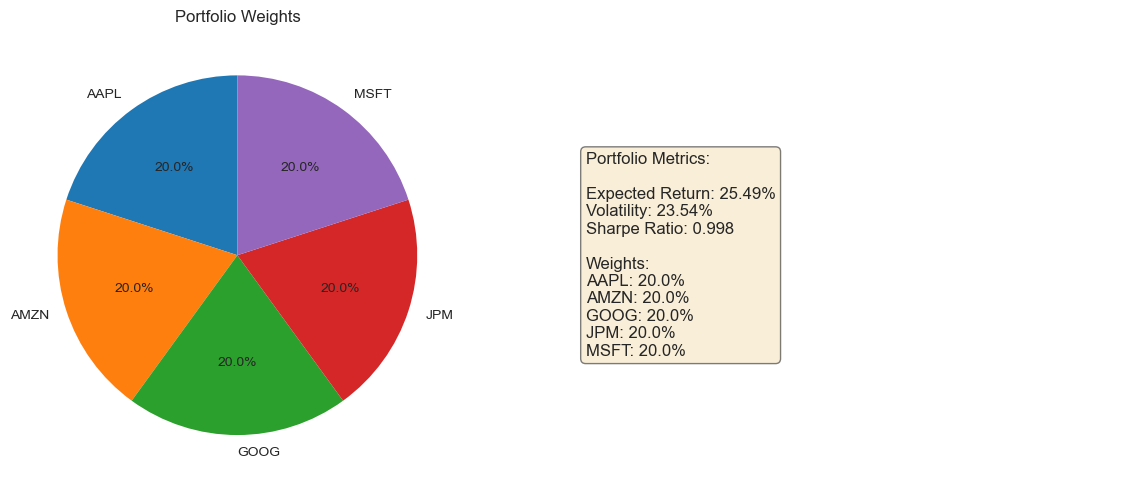


Growth-Focused Portfolio:


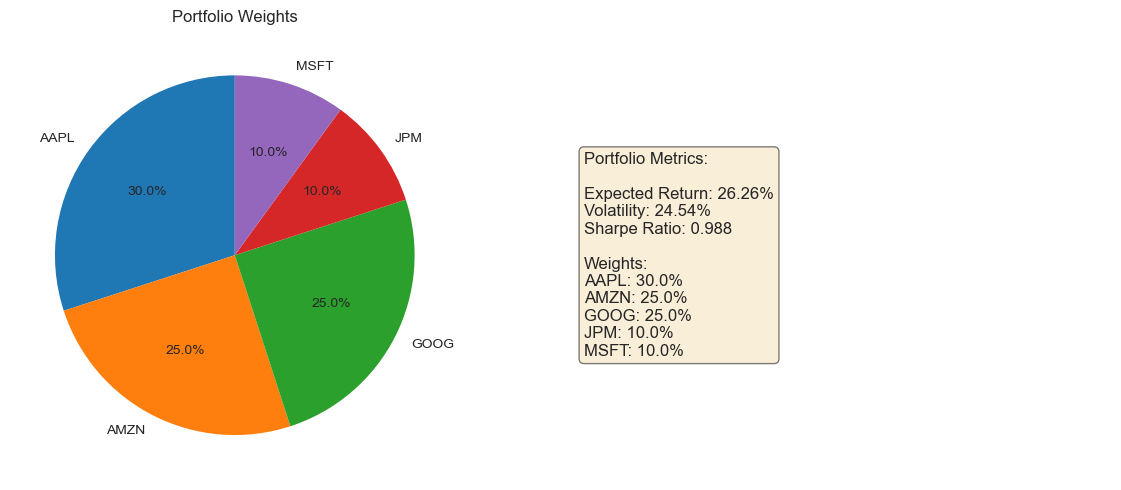


Conservative Portfolio:


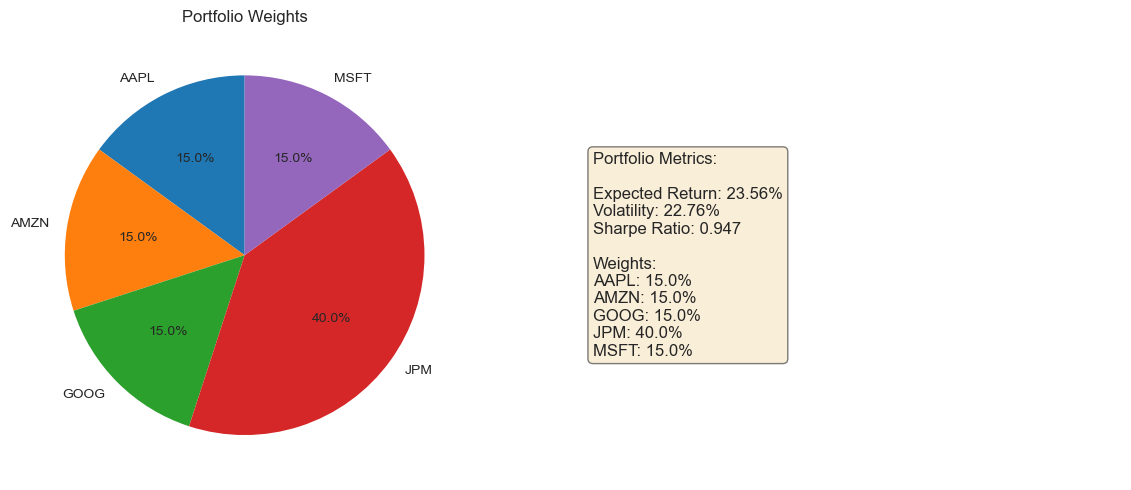

In [20]:
# Non-widget version that still allows interaction
def plot_portfolio_analysis(weights_dict):
    """Plot portfolio analysis for given weights"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Convert to array
    weights = np.array([weights_dict[asset] for asset in assets])
    weights = weights / weights.sum()  # Normalize
    
    # Calculate metrics
    port_return, port_vol = calculate_portfolio_stats(weights, expected_returns, cov_matrix)
    port_sharpe = (port_return - risk_free_rate) / port_vol
    
    # Pie chart
    ax1.pie(weights, labels=assets, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Portfolio Weights')
    
    # Metrics display
    metrics_text = f"""Portfolio Metrics:
    
Expected Return: {port_return:.2%}
Volatility: {port_vol:.2%}
Sharpe Ratio: {port_sharpe:.3f}

Weights:"""
    
    for asset, weight in zip(assets, weights):
        metrics_text += f"\n{asset}: {weight:.1%}"
    
    ax2.text(0.1, 0.5, metrics_text, fontsize=12, 
             transform=ax2.transAxes, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

# Test different portfolios
print("Equal Weight Portfolio:")
plot_portfolio_analysis({'AAPL': 0.2, 'AMZN': 0.2, 'GOOG': 0.2, 'JPM': 0.2, 'MSFT': 0.2})

print("\nGrowth-Focused Portfolio:")
plot_portfolio_analysis({'AAPL': 0.3, 'AMZN': 0.25, 'GOOG': 0.25, 'JPM': 0.1, 'MSFT': 0.1})

print("\nConservative Portfolio:")
plot_portfolio_analysis({'AAPL': 0.15, 'AMZN': 0.15, 'GOOG': 0.15, 'JPM': 0.4, 'MSFT': 0.15})

## 8. Comparison of All Strategies

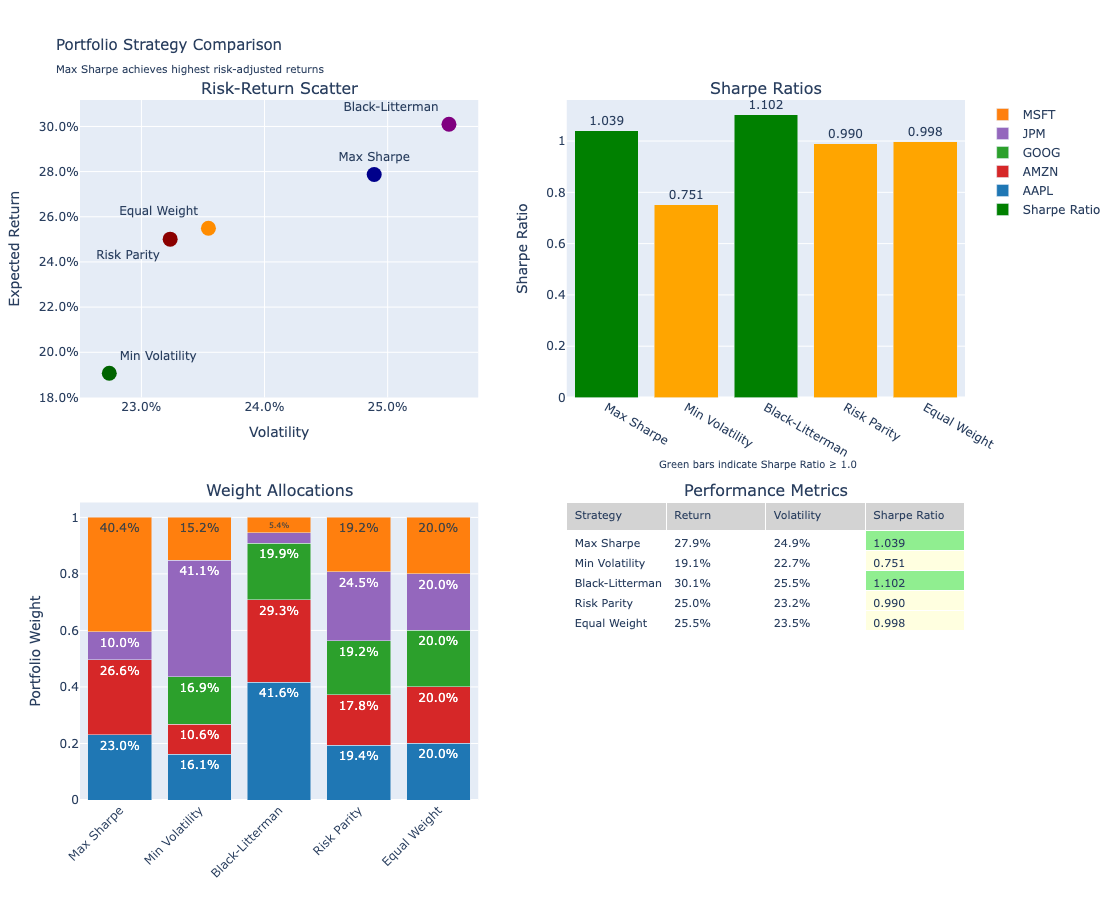

In [55]:
# Compile all strategies
all_strategies = {
    'Max Sharpe': strategies['Max Sharpe'],
    'Min Volatility': strategies['Min Volatility'],
    'Black-Litterman': strategies['Black-Litterman'],  # Add this line
    'Risk Parity': {
        'weights': rp_weights,
        'expected_return': rp_return,
        'volatility': rp_vol,
        'sharpe_ratio': rp_sharpe,
        'asset_names': assets
    },
    'Equal Weight': {
        'weights': np.array([1/n_assets] * n_assets),
        'expected_return': None,
        'volatility': None,
        'sharpe_ratio': None,
        'asset_names': assets
    }
}

# Calculate metrics for equal weight
ew_weights = all_strategies['Equal Weight']['weights']
ew_return, ew_vol = calculate_portfolio_stats(ew_weights, expected_returns, cov_matrix)
ew_sharpe = (ew_return - risk_free_rate) / ew_vol
all_strategies['Equal Weight']['expected_return'] = ew_return
all_strategies['Equal Weight']['volatility'] = ew_vol
all_strategies['Equal Weight']['sharpe_ratio'] = ew_sharpe

# Create comparison DataFrame
comparison_data = []
for name, strategy in all_strategies.items():
    if isinstance(strategy, dict):
        comparison_data.append({
            'Strategy': name,
            'Return': strategy['expected_return'],
            'Volatility': strategy['volatility'],
            'Sharpe': strategy['sharpe_ratio']
        })
    else:
        comparison_data.append({
            'Strategy': name,
            'Return': strategy.expected_return,
            'Volatility': strategy.volatility,
            'Sharpe': strategy.sharpe_ratio
        })

comparison_df = pd.DataFrame(comparison_data)

# Create comparison visualizations
# Create comparison visualizations with improved labeling and colors
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Risk-Return Scatter', 'Sharpe Ratios', 
                    'Weight Allocations', 'Performance Metrics'),
    specs=[[{'type': 'scatter'}, {'type': 'bar'}],
           [{'type': 'bar'}, {'type': 'table'}]],
    vertical_spacing=0.15,  # Add more space between rows
    horizontal_spacing=0.1
)

# Risk-Return Scatter with labeled points
for i, (name, strategy) in enumerate(all_strategies.items()):
    if isinstance(strategy, dict):
        ret = strategy['expected_return']
        vol = strategy['volatility']
        sharpe = strategy['sharpe_ratio']
    else:
        ret = strategy.expected_return
        vol = strategy.volatility
        sharpe = strategy.sharpe_ratio
    
    # Use different colors for each strategy
    colors = {
    'Max Sharpe': 'darkblue', 
    'Min Volatility': 'darkgreen', 
    'Risk Parity': 'darkred', 
    'Equal Weight': 'darkorange',
    'Black-Litterman': 'purple'  # Add this
}


    text_positions = {
    'Max Sharpe': 'top center',
    'Min Volatility': 'top right',
    'Black-Litterman': 'top left',
    'Risk Parity': 'bottom left',
    'Equal Weight': 'top left'
}    
    fig.add_trace(
        go.Scatter(
            x=[vol],
            y=[ret],
            mode='markers+text',
            marker=dict(size=15, color=colors.get(name, 'gray')),
            text=[name],  # Label each point
            textposition=text_positions.get(name, 'top center'),  # Use custom position
            name=name,
            showlegend=False  # We'll use the legend from another subplot
        ),
        row=1, col=1
    )

# Sharpe Ratios with color coding based on performance
sharpe_values = []
strategy_names = []
for name, strategy in all_strategies.items():
    strategy_names.append(name)
    if isinstance(strategy, dict):
        sharpe_values.append(strategy['sharpe_ratio'])
    else:
        sharpe_values.append(strategy.sharpe_ratio)

# Color bars based on Sharpe ratio value - higher is better
colors_sharpe = ['green' if s >= 1.0 else 'orange' if s >= 0.75 else 'red' 
                 for s in sharpe_values]

fig.add_trace(
    go.Bar(
        x=strategy_names,
        y=sharpe_values,
        marker_color=colors_sharpe,
        text=[f'{s:.3f}' for s in sharpe_values],  # Add value labels on bars
        textposition='outside',
        name='Sharpe Ratio'
    ),
    row=1, col=2
)

# Weight allocations (stacked bar) with better color scheme
# Define a consistent color scheme for assets
asset_colors = {
    'AAPL': '#1f77b4',   # Blue
    'MSFT': '#ff7f0e',   # Orange  
    'GOOG': '#2ca02c',   # Green
    'GOOGL': '#2ca02c',  # Same as GOOG
    'AMZN': '#d62728',   # Red
    'JPM': '#9467bd'     # Purple
}

# Create stacked bars for weight allocations
for i, asset in enumerate(assets):
    weights_data = []
    for name, strategy in all_strategies.items():
        if isinstance(strategy, dict):
            weights_data.append(strategy['weights'][i])
        else:
            weights_data.append(strategy.weights[i])
    
    fig.add_trace(
        go.Bar(
            x=list(all_strategies.keys()),
            y=weights_data,
            name=asset,
            marker_color=asset_colors.get(asset, 'gray'),
            text=[f'{w:.1%}' if w > 0.05 else '' for w in weights_data],  # Show percentages
            textposition='inside',
            textfont=dict(size=12)
        ),
        row=2, col=1
    )

# Performance table with formatted values
header_values = ['Strategy', 'Return', 'Volatility', 'Sharpe Ratio']
cell_values = [
    list(comparison_df['Strategy']),
    [f'{r:.1%}' for r in comparison_df['Return']],
    [f'{v:.1%}' for v in comparison_df['Volatility']],
    [f'{s:.3f}' for s in comparison_df['Sharpe']]
]

# Color code the Sharpe ratio column in the table
sharpe_colors = ['lightgreen' if s > 1.0 else 'lightyellow' if s > 0.75 else 'lightcoral' 
                 for s in comparison_df['Sharpe']]

fig.add_trace(
    go.Table(
        header=dict(
            values=header_values,
            fill_color='lightgray',
            align='left',
            font=dict(size=11)
        ),
        cells=dict(
            values=cell_values,
            fill_color=[['white']*len(comparison_df),  # Strategy column
                       ['white']*len(comparison_df),   # Return column
                       ['white']*len(comparison_df),   # Volatility column
                       sharpe_colors],                 # Sharpe column
            align='left',
            font=dict(size=11)
        )
    ),
    row=2, col=2
)

# Update layout with better formatting
fig.update_xaxes(tickformat='.1%', title_text='Volatility', row=1, col=1)
fig.update_yaxes(tickformat='.1%', title_text='Expected Return', row=1, col=1)
fig.update_yaxes(title_text='Sharpe Ratio', row=1, col=2)
fig.update_yaxes(title_text='Portfolio Weight', row=2, col=1)
fig.update_xaxes(tickangle=-45, row=2, col=1)  # Rotate labels for readability

fig.update_layout(
    height=900, 
    showlegend=True, 
    title_text='Portfolio Strategy Comparison<br><sub>Max Sharpe achieves highest risk-adjusted returns</sub>',
    title_font=dict(size=15),
    barmode='stack',
    margin=dict(t=100, b=100)  # Add margins for title and rotated labels
)

# Add annotations to explain the color coding
fig.add_annotation(
    text="Green bars indicate Sharpe Ratio ≥ 1.0",
    xref="paper", yref="paper",
    x=0.88, y=0.48,
    showarrow=False,
    font=dict(size=10)
)

fig.show()

## Key Takeaways

1. **Efficient Frontier**: Shows the best possible risk-return combinations
2. **Max Sharpe Portfolio**: Best risk-adjusted returns but may concentrate in few assets
3. **Min Volatility Portfolio**: Lowest risk but potentially lower returns
4. **Risk Parity**: Equal risk contribution from all assets, good for diversification
5. **Trade-offs**: Each strategy has different characteristics suitable for different investor objectives

## Next Steps
- Implement more advanced models (Black-Litterman, CVaR optimization)
- Add constraints (sector limits, position limits)
- Incorporate transaction costs in optimization
- Test robustness with different time periods